## Prepare Notebook

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [29]:
raw_df = pd.read_csv('../../data/basel_weather.csv')

data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

data_df = data_df.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

# Next, we aggregate by day. 
daily_data_df = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'temperature': np.mean}) \
    .set_index('date')

daily_data_df.head()

,year,month,day,dayofyear,temperature
date,,,,,
2008-01-01,2008,1,1,1,1.504620
2008-01-02,2008,1,2,2,-0.716971
2008-01-03,2008,1,3,3,1.312195
2008-01-04,2008,1,4,4,3.012195
2008-01-05,2008,1,5,5,7.090529


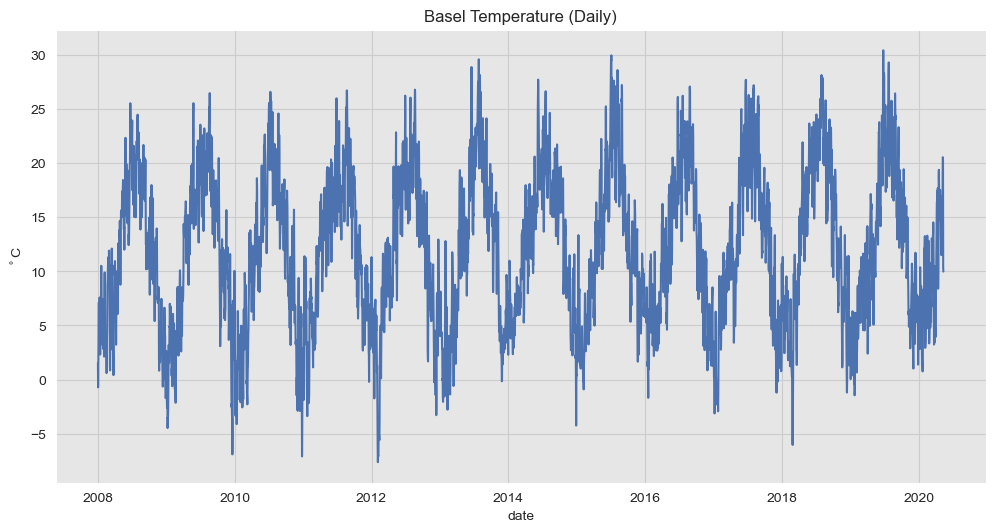

In [3]:
# Plot daily data. 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');

PeriodIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
             '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
             '2008-01-09', '2008-01-10',
             ...
             '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
             '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
             '2020-05-11', '2020-05-12'],
            dtype='period[D]', name='date', length=4516, freq='D')

In [36]:
from sktime.forecasting.model_selection import temporal_train_test_split

y = daily_data_df['temperature']
y.index = pd.PeriodIndex(y.index, freq='D') 

y_train, y_test = temporal_train_test_split(y, test_size=500)
fh = np.arange(len(y_test)) + 1

<AxesSubplot:xlabel='date', ylabel='temperature'>

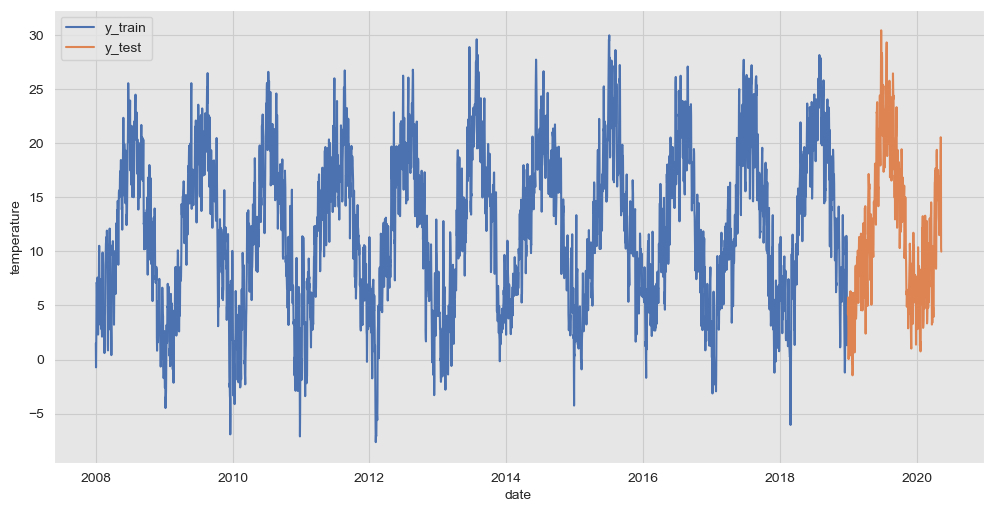

In [54]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index.to_timestamp(), y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index.to_timestamp(), y=y_test, color=sns_c[1], label='y_test', ax=ax)

<AxesSubplot:xlabel='date', ylabel='temperature'>

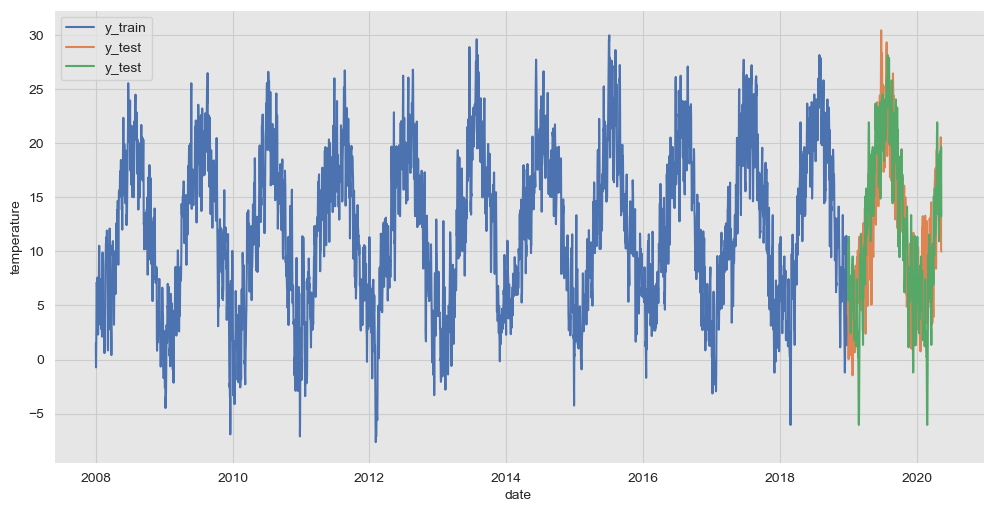

In [57]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='last', sp=365)
forecaster.fit(y_train=y_train)
y_pred = forecaster.predict(fh=fh)

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index.to_timestamp(), y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index.to_timestamp(), y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index.to_timestamp(), y=y_pred, color=sns_c[2], label='y_test', ax=ax)

<AxesSubplot:xlabel='date', ylabel='temperature'>

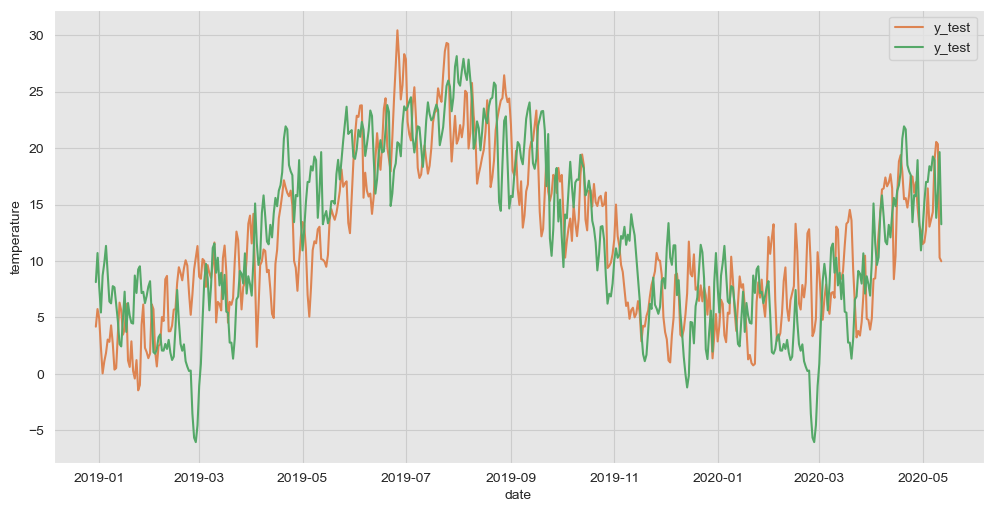

In [58]:
fig, ax = plt.subplots()
sns.lineplot(x=y_test.index.to_timestamp(), y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index.to_timestamp(), y=y_pred, color=sns_c[2], label='y_test', ax=ax)